In [1]:
# get the data file
!wget -N https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/train.csv

--2023-02-02 11:59:46--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/train.csv
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.107
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441947 (432K) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>] 431.59K   480KB/s    in 0.9s    

2023-02-02 11:59:48 (480 KB/s) - ‘train.csv’ saved [441947/441947]



In [2]:
# import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Dense, Activation, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import SGD

In [3]:
# read into csv file
df = pd.read_csv('train.csv')
df.head()

,sentence,BookRestaurant,GetWeather,PlayMusic,RateBook
0,book The Middle East restaurant in IN for noon,1,0,0,0
1,Book a table at T-Rex distant from Halsey St.,1,0,0,0
2,I'd like to eat at a taverna that serves chili...,1,0,0,0
3,I have a party of four in Japan and need a res...,1,0,0,0
4,Please make a restaurant reservation for somew...,1,0,0,0


In [4]:
# shuffle data
df = shuffle(df)
df.head()

,sentence,BookRestaurant,GetWeather,PlayMusic,RateBook
7235,I am giving Finding Chandra a 2 out of 6 rating,0,0,0,1
1437,I want a table for five at a restaurant with l...,1,0,0,0
2458,What is the weather forecast for my current pl...,0,1,0,0
2483,What's the temperature here,0,1,0,0
5513,Can I hear Anna Vissi's new music on Pandora?,0,0,1,0


In [5]:
X_train = df["sentence"].fillna("fillna").values
y_train = df[["BookRestaurant", "GetWeather", "PlayMusic", "RateBook"]].values

In [6]:
X_train.shape, y_train.shape

((7929,), (7929, 4))

In [7]:
X_train[1], y_train[1] 

('I want a table for five at a restaurant with latin food in Arkansas for 1 hour from now',
 array([1, 0, 0, 0]))

In [8]:
text = X_train
# text preprocessing
Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(text) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
Tokenizer_vocab_size, X_train.shape, y_train.shape

(7522, (7929,), (7929, 4))

In [9]:

samples = 2200

X_train = X_train[samples:] 
y_train = y_train[samples:] 

X_val = X_train[:samples] 
y_val = y_train[:samples] 

X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = 4000)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = 4000)

X_train_encoded_padded_words.shape, X_val_encoded_padded_words.shape

((5729, 4000), (2200, 4000))

In [10]:
X_val_encoded_padded_words, X_train_encoded_padded_words


(array([[   0,    0,    0, ...,  771,   19,   10],
        [   0,    0,    0, ...,  530,  530,  945],
        [   0,    0,    0, ...,    1, 1906,   18],
        ...,
        [   0,    0,    0, ...,   15,    3, 1034],
        [   0,    0,    0, ..., 5364,   14,  186],
        [   0,    0,    0, ...,  239, 5365,  522]], dtype=int32),
 array([[   0,    0,    0, ...,  771,   19,   10],
        [   0,    0,    0, ...,  530,  530,  945],
        [   0,    0,    0, ...,    1, 1906,   18],
        ...,
        [   0,    0,    0, ...,   18,    3,  479],
        [   0,    0,    0, ...,   25,   77,   70],
        [   0,    0,    0, ...,  166,    5,  554]], dtype=int32))

In [11]:

model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 32, input_length = 4000)) 

model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4000, 32)          240704    
                                                                 
 lstm (LSTM)                 (None, 10)                1720      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 800)               8800      
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               160200    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0

In [12]:
Nadam = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [13]:
history  = model.fit(X_train_encoded_padded_words,y_train, epochs = 3, batch_size=32, verbose=1, validation_data=(X_val_encoded_padded_words, y_val))


Epoch 1/3
180/180 [==============================] - 431s 2s/step - loss: 0.3686 - accuracy: 0.8481 - val_loss: 0.0156 - val_accuracy: 0.9959
Epoch 2/3
180/180 [==============================] - 408s 2s/step - loss: 0.0818 - accuracy: 0.9677 - val_loss: 0.0082 - val_accuracy: 0.9973
Epoch 3/3
180/180 [==============================] - 409s 2s/step - loss: 0.0760 - accuracy: 0.9698 - val_loss: 0.0073 - val_accuracy: 0.9982


In [14]:
# save the model
model.save("Intent_Classification.h5")

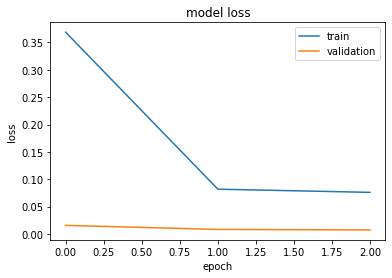

In [15]:
#loss
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [18]:
model.evaluate(X_val_encoded_padded_words, y_val)


69/69 [==============================] - 22s 323ms/step - loss: 0.0073 - accuracy: 0.9982


[0.007305637933313847, 0.9981818199157715]

In [43]:
import numpy as np

np.reshape(X_train, (5729,1)) 

array([['Book a restaurant in FL in the city of Lochearn for my step son and I'],
       ['What will the weather by close by the current position at 02:02:30?'],
       ['I want to make a reservation at a sushi restaurant'],
       ...,
       ['Book a table for three at a restaurant in Louisiana'],
       ['How chilly will it get here?'],
       ['will it get chillier within walking distance of PW']],
      dtype=object)

In [44]:
def predict(text):
    sentence = text
    tokens = Tokenizer.texts_to_sequences([text])
    tokens = pad_sequences(tokens, maxlen = 100)
    prediction = model.predict(np.array(tokens))
    pred = np.argmax(prediction)
    classes = ['BookRestaurant','GetWeather','PlayMusic','RateBook']
    result = classes[pred]
    return result

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()
a = min_max_scaler.fit_transform(df)
new = min_max_scaler.inverse_transform(normalized_value)
return new
p = model.predict(X_test)
newp = denormalize(df, p)
newy_test = denormalize(df, y_test)


NameError: ignored

In [54]:
def F_score(newp,newy_test):
    TP=0
    FN=0
    FP=0
    for i in range(len(newp)-1):
        test_prof=newy_test[i+1]-newy_test[i]
        p_prof=newp[i+1] - newp[i]

        if((test_prof>=0) and (p_prof>=0)):
            TP=TP+1
        if ((test_prof>= 0) and (p_prof<0)):
            FN=FN+1
        if ((test_prof<0) and (p_prof>=0)):
            FP=FP+1

    Precision=float(TP)/float(TP+FP)
    Recall=float(TP)/float(TP+FN)

    Fscore= 2.0*Precision*Recall/(Precision+Recall)
    print('classification F score: %.5f' % (Fscore))
    return Fscore

NameError: ignored